# CAD Project - Skin Lesion Classification

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
TRAIN_PATH = '/content/drive/My Drive/CAD PROJECT/DERMO/train'
VAL_PATH = '/content/drive/My Drive/CAD PROJECT/DERMO/val'
Test_PATH = '/content/drive/My Drive/CAD PROJECT/DERMO/test'

In [0]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
import itertools
from sklearn.metrics import classification_report

import copy

plt.ion()   # interactive mode

## 1.1. Path

In [0]:
data_dir = '/content/drive/My Drive/CAD PROJECT/Dermo_Train_Val/' #DERMO, #Dermo_color, Dermo1, Dermo_Inpainted

options = {}

# input image size
# inception_v3 requires the input size to be (299,299), whereas all of the other models  (224,224).
options['input_size'] = (224,224)
target_size = 256
# normalization mean
options['normalize_mean'] = [0.485, 0.456, 0.406]

# normalization mean
options['normalize_std'] = [0.229, 0.224, 0.225]

options["models"]='/content/drive/My Drive/CAD PROJECT/Results/SKIN_MODELS/FINAL_MODEL/'

resultdir = "/content/drive/My Drive/CAD PROJECT/Results/SKIN_RESULTS/FINAL_RESULT/" 
Test_PATH = '/content/drive/My Drive/CAD PROJECT/DERMO/test'

## 1.2 Hyperparameters

In [0]:
############################################################################################
# Hyperparameters
############################################################################################

BATCHSIZE = 16
options["model_type"] = "vgg16"

options["optim"] = "sgd"
options["losstype"] = "crossentropy" #focalloss, # crossentropy
lrate = 1e-3     #default 0.001
weightdecay = 1e-4    #default 0.0001

num_epochs = 4
earlystopping = 15

excel_name = '/final_dermo_test_results_best_final'
exp_name = "FINAL_Skinmodel_augmentaffine_train_val_batchsize"+str(BATCHSIZE)+"_"+options["model_type"]+"_"+options["losstype"]+"_"+options["optim"]+"_epoch"+str(num_epochs)

In [7]:
exp_name

'FINAL_Skinmodel_augmentaffine_train_val_batchsize16_vgg16_crossentropy_sgd_epoch4'

# 2. Data Preparation

## 2.1 Data augmentation and normalization

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(target_size), 
        transforms.RandomCrop(options['input_size'], padding=None, pad_if_needed=True),
        transforms.ColorJitter(brightness=(0.9,1.1), contrast=(0.9,1.1), saturation=(0.9,1.1)),
        transforms.RandomAffine(30,shear=20),
        # transforms.RandomApply([colour_transform],p=1.0),
        # transforms.RandomRotation(degrees=30),
        transforms.RandomHorizontalFlip(),  
        transforms.RandomVerticalFlip(),        
        transforms.ToTensor(),
        transforms.Normalize(options['normalize_mean'], options['normalize_std']) #calculated_mean, calculated_std for mean 0 and std 1
    ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(target_size), 
        transforms.CenterCrop(options['input_size']),     
        transforms.ToTensor(),
        transforms.Normalize(options['normalize_mean'], options['normalize_std'])
    ]),
    'val': transforms.Compose([
        transforms.Resize(target_size), 
        transforms.CenterCrop(options['input_size']),     
        transforms.ToTensor(),
        transforms.Normalize(options['normalize_mean'], options['normalize_std'])
    ]),
}
# x = 'train'

# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) }

# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCHSIZE,
#                                              shuffle=True, num_workers=4)}

###########################################
#Testing images
###########################################

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCHSIZE,
                                             shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)
print(class_names)

{'train': 5700, 'val': 300}
['les', 'nv']


In [0]:
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [0]:
from skimage import io, transform

class TestDataset(torch.utils.data.Dataset):
    """Test dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dirs_all = os.listdir(root_dir)
        self.dirs_all.sort(key=natural_keys)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dirs_all)

    def __getitem__(self, idx):
        
        img_name = os.path.join(self.root_dir, self.dirs_all[idx])
        
        image = io.imread(img_name)
        
        if self.transform:
            image = self.transform(image)

        return image

In [0]:
image_datasets['test'] = TestDataset(Test_PATH, data_transforms['test'])
test_dataLoader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=BATCHSIZE, shuffle=False, num_workers=4)

In [12]:
len(image_datasets['test'])

1015

## 2.1 Utils (functions)

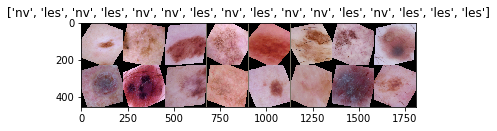

In [13]:
def plotMetrics(training_acc, val_acc, training_loss, val_loss, exp_name):        
    current_time = time.time()
    result_dir = '/content/drive/My Drive/CAD PROJECT/Results/SKIN_RESULTS'
    # training and val accuracy
    epoch_list = tuple(range(0,len(training_acc),1))
    plt.plot(training_acc)
    plt.plot(val_acc)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')    
    acc_path = resultdir + "/accuracy_"+exp_name+".png"
    plt.savefig(acc_path)   
    plt.show() 

    # training and val loss
    plt.plot(training_loss)
    plt.plot(val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')    
    loss_path = resultdir + "/loss_"+exp_name+".png"
    plt.savefig(loss_path) 
    plt.show()
 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    conf_path = resultdir + "/conf_"+exp_name+".png"
    plt.savefig(conf_path) 
    
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(options['normalize_mean'])
    std = np.array(options['normalize_std'])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

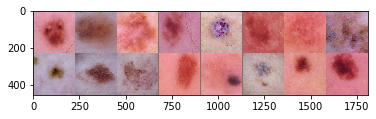

In [14]:
# Get a batch of testing data
inputs = next(iter(test_dataLoader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out)


In [15]:
inputs.shape

torch.Size([16, 3, 224, 224])

# 3. Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.

## Loss Function

In [0]:
class FocalLoss(nn.Module):
    '''
    Multi-class Focal loss implementation
    '''
    def __init__(self, gamma=2, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, input, target):
        """
        input: [N, C]
        target: [N, ]
        """
        logpt = F.log_softmax(input, dim=1)
        pt = torch.exp(logpt)
        logpt = (1-pt)**self.gamma * logpt
        loss = F.nll_loss(logpt, target, self.weight)
        return loss

## Choose Model

In [17]:

is_inception = False
if options["model_type"] == "inceptionv3":
  is_inception = True
  skin_model = models.inception_v3(pretrained=True)
  num_in_ftrs1 = skin_model.AuxLogits.fc.in_features
  skin_model.AuxLogits.fc = nn.Linear(num_in_ftrs1, 2)  
  num_in_ftrs = skin_model.fc.in_features
  skin_model.fc = nn.Linear(num_in_ftrs, 2)
elif options["model_type"] == "resnet":  
  skin_model = models.resnet50(pretrained=True)
  num_in_ftrs = skin_model.fc.in_features
  skin_model.fc = nn.Linear(num_in_ftrs, 2)
elif options["model_type"] == "densenet":  
  skin_model = models.densenet161(pretrained=True)
  num_in_ftrs = skin_model.classifier.in_features
  skin_model.classifier = nn.Linear(num_in_ftrs, 2)
elif options["model_type"] == "vgg16":  
  skin_model = models.vgg19_bn(pretrained=True)
  num_in_ftrs = skin_model.classifier[6].in_features
  skin_model.classifier[6] = nn.Linear(num_in_ftrs, 2)
elif options["model_type"] == "senet":  
  skin_model = se_resnet152(pretrained='imagenet')
  num_in_ftrs = skin_model.last_linear.in_features
  skin_model.last_linear = nn.Linear(num_in_ftrs, 2)
elif options["model_type"] == "resnext":  #Aggregated Residual Transformations
  skin_model = models.resnext101_32x8d(pretrained=True)
  num_in_ftrs = skin_model.fc.in_features
  skin_model.fc = nn.Linear(num_in_ftrs, 2)  
elif options["model_type"] == "mobilenetV2":  
  skin_model = models.mobilenet_v2(pretrained=True)
  num_in_ftrs = skin_model.classifier[1].in_features
  skin_model.classifier[1] = nn.Linear(num_in_ftrs, 2)
else:
  print("Please choose the correct model")

# Change the last fully connected layer (the only fc layer in model)
 

for name, child in skin_model.named_children():
    print(name)

skin_model = skin_model.to(device)
if options["losstype"] == "focalloss":
  criterion = FocalLoss()
elif options["losstype"] == "crossentropy": 
  criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized

if options["optim"] == "sgd":
  optimizer = optim.SGD(skin_model.parameters(), lr=lrate, momentum=0.9)
elif options["optim"] == "adadelta":  
  optimizer = optim.Adadelta(skin_model.parameters(), lr=lrate, weight_decay=weightdecay)
elif options["optim"] == "adam":  
  optimizer = optim.Adam(skin_model.parameters(), lr=lrate, weight_decay=weightdecay) #weight_decay, lambda, L2 regularization
else:
  print("Please choose correct optimizer")

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

total_trainable_params = sum(
    p.numel() for p in skin_model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')
#print(skin_model)

features
avgpool
classifier
139,589,442 training parameters.


## Train and Evaluate


In [18]:

mytime = time.strftime("%Y_%m_%d_%HH_%MM")
model_name = exp_name+'_' + mytime
try:
  since = time.time()

  best_model_wts = copy.deepcopy(skin_model.state_dict())  # intialize with the pretrained weights, state_dict -> load_weight
  best_acc = 0.0
  best_loss = 1e+5
  training_loss = []
  training_acc = []
  val_loss = []
  val_acc = []

  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)

      # Each epoch has a training and validation phase
      phase = 'train'
      if phase == 'train':              
          skin_model.train()  # Set model to training mode
      else:
          skin_model.eval()   # Set model to evaluate/testing mode -- dropout, batchnorm will behave differently

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward
          # track history if only in train
          with torch.set_grad_enabled(phase == 'train'):
              
              # Special case for inception because in training it has an auxiliary output
              if is_inception and phase == 'train':                    
                outputs, aux_outputs = skin_model(inputs)
                loss1 = criterion(outputs, labels)
                loss2 = criterion(aux_outputs, labels)
                loss = loss1 + 0.4*loss2
              else:
                outputs = skin_model(inputs)
                loss = criterion(outputs, labels)

              _, preds = torch.max(outputs, 1) #argmax
              

              # backward + optimize only if in training phase
              if phase == 'train':
                  loss.backward()
                  optimizer.step()

          # statistics
          #loss.item() returns the average loss in a batch.... loss.item() * inputs.size(0)= total loss in a batch
          running_loss += loss.item() * inputs.size(0) 
          running_corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss / dataset_sizes[phase] # total loss of all images / no of images
      epoch_acc = running_corrects.double() / dataset_sizes[phase] # total no of correctly predicted images / no of images

      # Save the training and val acc + loss
      if phase == 'train':
        training_acc.append(epoch_acc)
        training_loss.append(epoch_loss)
      else:
        val_acc.append(epoch_acc)
        val_loss.append(epoch_loss)


      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
          phase, epoch_loss, epoch_acc))
                
      # deep copy the model ( Make a copy of the model if the accuracy on the validation set has improved)
      if phase == 'train' and epoch_loss < best_loss:
          best_loss = epoch_loss
          best_acc = epoch_acc
          print("training loss decreased...saving model")
          best_model_wts = copy.deepcopy(skin_model.state_dict()) #copy its weights
          torch.save(skin_model.state_dict(), 
                os.path.join(options['models'], model_name +'.pt'))                    
        

      print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best training Acc: {:4f}'.format(best_acc))
  print('Best training Loss: {:4f}'.format(best_loss))

  # load best model weights
  skin_model.load_state_dict(best_model_wts) #

#Don't show an error during keyboard...
except KeyboardInterrupt:
    pass

Epoch 0/3
----------
train Loss: 0.4174 Acc: 0.8033
training loss decreased...saving model

Epoch 1/3
----------
train Loss: 0.3448 Acc: 0.8482
training loss decreased...saving model

Epoch 2/3
----------
train Loss: 0.3008 Acc: 0.8654
training loss decreased...saving model

Epoch 3/3
----------
train Loss: 0.2952 Acc: 0.8693
training loss decreased...saving model

Training complete in 5m 55s
Best training Acc: 0.869298
Best training Loss: 0.295158


In [19]:
outputs.shape

torch.Size([4, 2])

In [20]:
labels.shape

torch.Size([4])

In [21]:
model_name

'FINAL_Skinmodel_augmentaffine_train_val_batchsize16_vgg16_crossentropy_sgd_epoch4_2020_01_14_00H_26M'

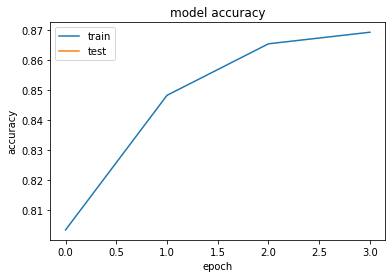

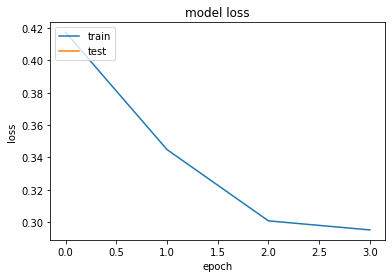

In [22]:
plotMetrics(training_acc, val_acc, training_loss, val_loss, model_name)

# 4. Prediction

## 4.1 Prediction on Test

In [0]:
if False:
  options['gpu_use'] = True
  # options["models"]='/content/drive/My Drive/CAD PROJECT/Results/SKIN_MODELS/'
  device = torch.device('cuda') if options['gpu_use'] else torch.device('cpu')
  skin_model = models.densenet161(pretrained=True)
  num_in_ftrs = skin_model.classifier.in_features
  skin_model.classifier = nn.Linear(num_in_ftrs, 2) 

  skin_model = skin_model.to(device)  
  skin_model.load_state_dict(torch.load(os.path.join(os.path.join(options['models'], 'FINAL_Skinmodel_augmentaffine_batchsize16_densenet_crossentropy_adadelta_epoch45_2020_01_13_12H_21M'+'.pt'))))

nb_classes = 2


y_predict = []
with torch.no_grad():
    for i, (inputs) in enumerate(test_dataLoader):
        inputs = inputs.to(device)        
        outputs = skin_model(inputs)
        _, preds = torch.max(outputs, 1)        
        y_predict.extend(np.squeeze(outputs.max(1, keepdim=True)[1].cpu().numpy().T))        


# convert from ['les', 'nv'] to classification result (0= nev and 1=les)
y_predict_old = y_predict
for i in range(len(y_predict)):
  if y_predict_old[i] == 0:
    y_predict[i] = 1
  elif y_predict_old[i] == 1:
    y_predict[i] = 0

## convert your array into a dataframe
# df = pd.DataFrame (y_predict)

# ## save to xlsx file

# filepath = resultdir + excel_name+'_'+exp_name +mytime+'.xlsx'

# df.to_excel(filepath, index=False)

#######################
# Note: 
#######################
# ['les', 'nv']
# confusion_matrix[0, 0] when both gt and pred are class zero, confusion_matrix[0, 1] when gt is 0 and pred is 1
# confusion_matrix[1, 0] when gt is 1 and pred is 0,           confusion_matrix[1, 1] when both gt and pred are class 1

In [0]:
df = pd.DataFrame (y_predict)

## save to xlsx file

filepath = resultdir + excel_name+'_'+exp_name +mytime+'.xlsx'

df.to_excel(filepath, index=False)

In [26]:
import xlrd
book = xlrd.open_workbook(filepath)
sheet = book.sheet_by_name('Sheet1')
pred_teddy = [[sheet.cell_value(r, c) for c in range(sheet.ncols)] for r in range(sheet.nrows)]
pred_teddy = np.array(pred_teddy, dtype=np.int)
pred_teddy.shape

(1016, 1)

In [54]:
import xlrd
book = xlrd.open_workbook(resultdir +'skin_test_results.xlsx')
sheet = book.sheet_by_name('Sheet1')
pred_zohaib = [[sheet.cell_value(r, c) for c in range(sheet.ncols)] for r in range(sheet.nrows)]
pred_zohaib = np.array(pred_zohaib, dtype=np.int)
pred_zohaib.shape
# len(pred_zohaib)

(1015, 1)

In [0]:
# y_predict = np.array(y_predict, dtype=np.int)
# y_predict = y_predict.reshape(-1,1)
# y_predict.shape

In [56]:
np.count_nonzero((pred_teddy == pred_zohaib)*1)/len(pred_teddy)

0.8167487684729065

In [52]:
np.count_nonzero(pred_zohaib)

453

In [40]:
plot_confusion_matrix(confusion_matrix, class_names)

# Generate a classification report
report = classification_report(y_label, y_predict, target_names=class_names)
print(report)

NameError: ignored

In [25]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = skin_model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print("Training Confusion Matrix:")
print(confusion_matrix)
print("\nTraining per-class accuracy:")
print(confusion_matrix.diag()/confusion_matrix.sum(1))



Training Confusion Matrix:
tensor([[133.,  17.],
        [ 28., 122.]])

Training per-class accuracy:
tensor([0.8867, 0.8133])


## 4.2 Confusion matrix for training

In [23]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['train']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = skin_model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print("Training Confusion Matrix:")
print(confusion_matrix)
print("\nTraining per-class accuracy:")
print(confusion_matrix.diag()/confusion_matrix.sum(1))


# resultdir = "/content/drive/My Drive/CAD PROJECT/Results/SKIN_RESULTS/"
# per_class_acc = confusion_matrix.diag()/confusion_matrix.sum(1)
# accuracy = [(per_class_acc[0] + per_class_acc[1]).cpu().numpy() / 2, 0]
# sensitivity = [(confusion_matrix[1,1] / (confusion_matrix[1,1] + confusion_matrix[0,1])).cpu().numpy(), 0]
# specificity = [(confusion_matrix[0,0] / (confusion_matrix[0,0] + confusion_matrix[1,0])).cpu().numpy(), 0]

# confusion_matrix = confusion_matrix.cpu().numpy()
# per_class_acc = per_class_acc.cpu().numpy()

# pred_class = ['pred_positive(les)', 'pred_negative(nv)']
# conf_dict = {"Predected\actuall": pred_class, "actuall_positive(les)": confusion_matrix[:,0], 
#              "actual_negative(nv)": confusion_matrix[:,1], "per_class_acc": per_class_acc, 
#              "sensitivity": sensitivity, "specificity": specificity}

# train_df = pd.DataFrame(conf_dict, columns=['Predected\actuall', 'actuall_positive(les)', 'actual_negative(nv)', 'per_class_acc', 'sensitivity', 'specificity'])
# train_df_csv_path = resultdir + "/train_confusionMatrix"+'_'+model_name+".csv"
# train_df.to_csv(train_df_csv_path)
# confusion_matrix[0,0] when both gt and pred are class zero, confusion_matrix[0,1] when gt is 0 and pred is 1
# confusion_matrix[1,0] when gt is 1 and pred is 0,     confusion_matrix[1,1] when both gt and pred are class 1

Training Confusion Matrix:
tensor([[2908.,   92.],
        [ 243., 2757.]])

Training per-class accuracy:
tensor([0.9693, 0.9190])


In [42]:
image.max()

255

# 5. Ensemble Models

In [0]:
def ensemble_models():
  

# 6. Visualizing the wrong model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images


In [0]:
def visualize_model(model, num_images=32):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):

                if class_names[preds[j]] != class_names[labels[j]]:
                  images_so_far += 1

                  #print('predicted: {}, groundtruth:{}'.format(class_names[preds[j]], class_names[labels[j]]))                                
                  imshow(inputs.cpu().data[j], ('predicted: {}, groundtruth:{}'.format(class_names[preds[j]], class_names[labels[j]])))                
                

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

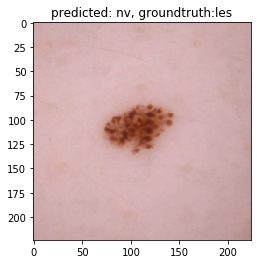

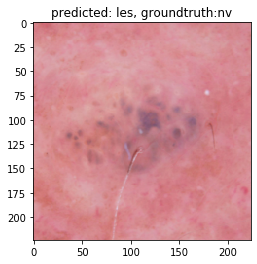

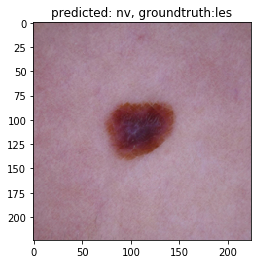

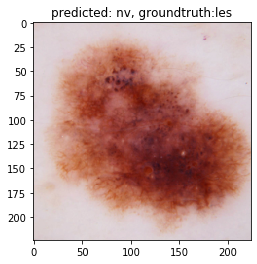

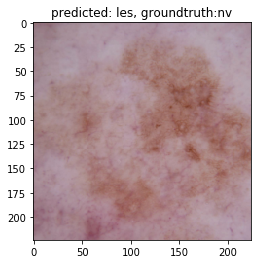

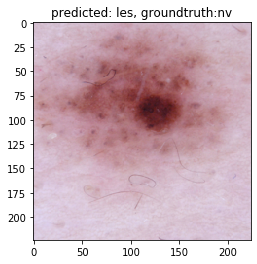

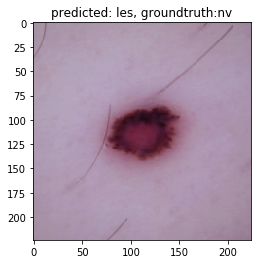

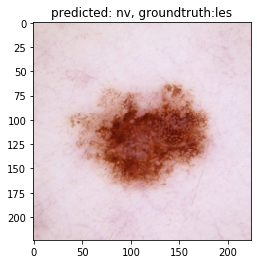

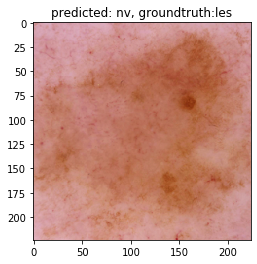

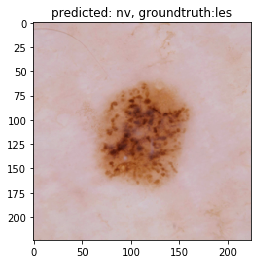

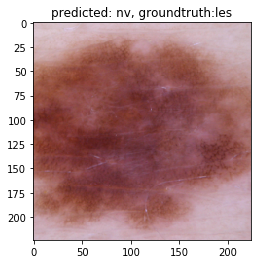

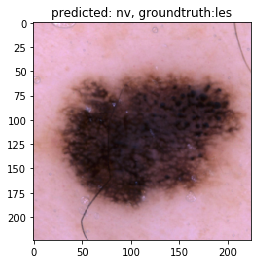

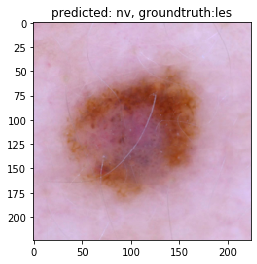

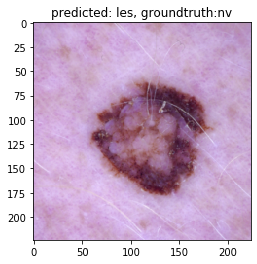

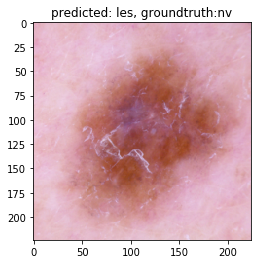

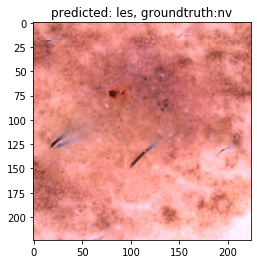

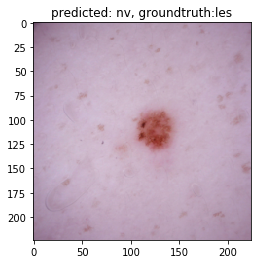

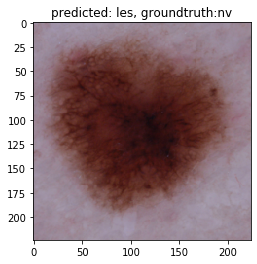

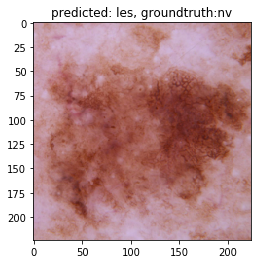

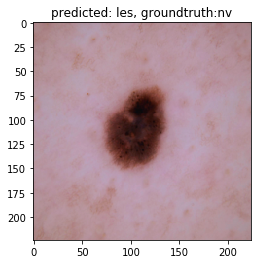

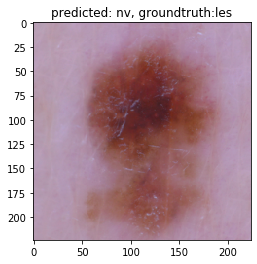

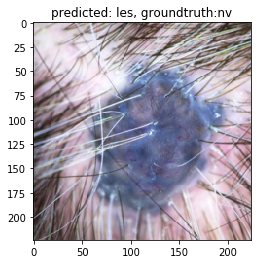

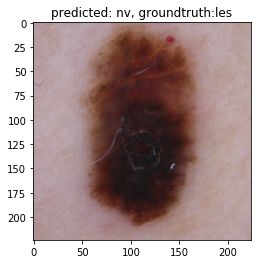

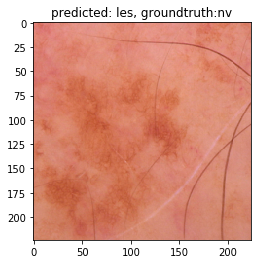

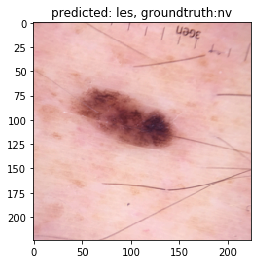

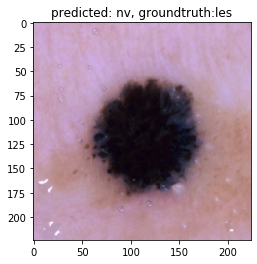

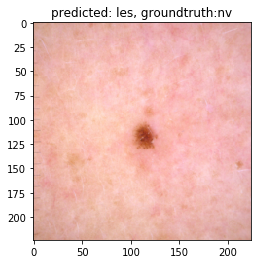

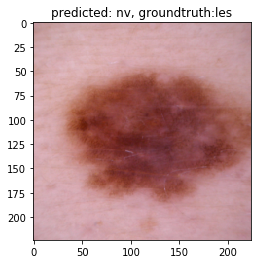

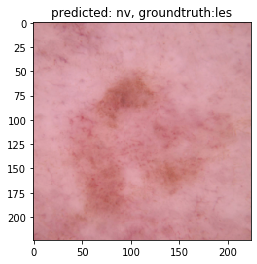

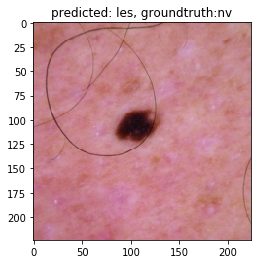

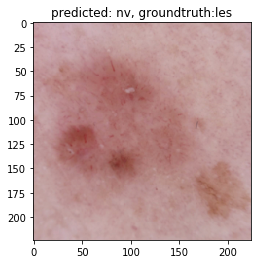

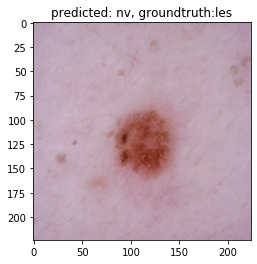

In [0]:
visualize_model(skin_model,BATCHSIZE)

In [0]:
def train_model(skin_model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(skin_model.state_dict())  # intialize with the pretrained weights, state_dict -> load_weight
    best_acc = 0.0
    training_loss = []
    training_acc = []
    val_loss = []
    val_acc = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step()
                skin_model.train()  # Set model to training mode
            else:
                skin_model.eval()   # Set model to evaluate/testing mode -- dropout, batchnorm will behave differently

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = skin_model(inputs)
                    _, preds = torch.max(outputs, 1) #argmax
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                #loss.item() returns the average loss in a batch.... loss.item() * inputs.size(0)= total loss in a batch
                running_loss += loss.item() * inputs.size(0) 
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase] # total loss of all images / no of images
            epoch_acc = running_corrects.double() / dataset_sizes[phase] # total no of correctly predicted images / no of images

            # Save the training and val acc + loss
            if phase == 'train':
              training_acc.append(epoch_acc)
              training_loss.append(epoch_loss)
            else:
              val_acc.append(epoch_acc)
              val_loss.append(epoch_loss)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model ( Make a copy of the model if the accuracy on the validation set has improved)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(skin_model.state_dict()) #copy the its weights

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    skin_model.load_state_dict(best_model_wts) #
    return skin_model, training_acc, val_acc, training_loss, val_loss

# 7. Implementation of **SENET**

In [0]:
"""
ResNet code gently borrowed from
https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
"""
from __future__ import print_function, division, absolute_import
from collections import OrderedDict
import math

import torch.nn as nn
from torch.utils import model_zoo

__all__ = ['SENet', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152',
           'se_resnext50_32x4d', 'se_resnext101_32x4d']

pretrained_settings = {
    'senet154': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/senet154-c7b49a05.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnet50': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet50-ce0d4300.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnet101': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet101-7e38fcc6.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnet152': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet152-d17c99b7.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnext50_32x4d': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnext101_32x4d': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext101_32x4d-3b2fe3d8.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
}


class SEModule(nn.Module):

    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x


class Bottleneck(nn.Module):
    """
    Base class for bottlenecks that implements `forward()` method.
    """
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = self.se_module(out) + residual
        out = self.relu(out)

        return out


class SEBottleneck(Bottleneck):
    """
    Bottleneck for SENet154.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes * 2)
        self.conv2 = nn.Conv2d(planes * 2, planes * 4, kernel_size=3,
                               stride=stride, padding=1, groups=groups,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 4)
        self.conv3 = nn.Conv2d(planes * 4, planes * 4, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNetBottleneck(Bottleneck):
    """
    ResNet bottleneck with a Squeeze-and-Excitation module. It follows Caffe
    implementation and uses `stride=stride` in `conv1` and not in `conv2`
    (the latter is used in the torchvision implementation of ResNet).
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEResNetBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False,
                               stride=stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1,
                               groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNeXtBottleneck(Bottleneck):
    """
    ResNeXt bottleneck type C with a Squeeze-and-Excitation module.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None, base_width=4):
        super(SEResNeXtBottleneck, self).__init__()
        width = math.floor(planes * (base_width / 64)) * groups
        self.conv1 = nn.Conv2d(inplanes, width, kernel_size=1, bias=False,
                               stride=1)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride,
                               padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SENet(nn.Module):

    def __init__(self, block, layers, groups, reduction, dropout_p=0.2,
                 inplanes=128, input_3x3=True, downsample_kernel_size=3,
                 downsample_padding=1, num_classes=1000):
        """
        Parameters
        ----------
        block (nn.Module): Bottleneck class.
            - For SENet154: SEBottleneck
            - For SE-ResNet models: SEResNetBottleneck
            - For SE-ResNeXt models:  SEResNeXtBottleneck
        layers (list of ints): Number of residual blocks for 4 layers of the
            network (layer1...layer4).
        groups (int): Number of groups for the 3x3 convolution in each
            bottleneck block.
            - For SENet154: 64
            - For SE-ResNet models: 1
            - For SE-ResNeXt models:  32
        reduction (int): Reduction ratio for Squeeze-and-Excitation modules.
            - For all models: 16
        dropout_p (float or None): Drop probability for the Dropout layer.
            If `None` the Dropout layer is not used.
            - For SENet154: 0.2
            - For SE-ResNet models: None
            - For SE-ResNeXt models: None
        inplanes (int):  Number of input channels for layer1.
            - For SENet154: 128
            - For SE-ResNet models: 64
            - For SE-ResNeXt models: 64
        input_3x3 (bool): If `True`, use three 3x3 convolutions instead of
            a single 7x7 convolution in layer0.
            - For SENet154: True
            - For SE-ResNet models: False
            - For SE-ResNeXt models: False
        downsample_kernel_size (int): Kernel size for downsampling convolutions
            in layer2, layer3 and layer4.
            - For SENet154: 3
            - For SE-ResNet models: 1
            - For SE-ResNeXt models: 1
        downsample_padding (int): Padding for downsampling convolutions in
            layer2, layer3 and layer4.
            - For SENet154: 1
            - For SE-ResNet models: 0
            - For SE-ResNeXt models: 0
        num_classes (int): Number of outputs in `last_linear` layer.
            - For all models: 1000
        """
        super(SENet, self).__init__()
        self.inplanes = inplanes
        if input_3x3:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, 64, 3, stride=2, padding=1,
                                    bias=False)),
                ('bn1', nn.BatchNorm2d(64)),
                ('relu1', nn.ReLU(inplace=True)),
                ('conv2', nn.Conv2d(64, 64, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn2', nn.BatchNorm2d(64)),
                ('relu2', nn.ReLU(inplace=True)),
                ('conv3', nn.Conv2d(64, inplanes, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn3', nn.BatchNorm2d(inplanes)),
                ('relu3', nn.ReLU(inplace=True)),
            ]
        else:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, inplanes, kernel_size=7, stride=2,
                                    padding=3, bias=False)),
                ('bn1', nn.BatchNorm2d(inplanes)),
                ('relu1', nn.ReLU(inplace=True)),
            ]
        # To preserve compatibility with Caffe weights `ceil_mode=True`
        # is used instead of `padding=1`.
        layer0_modules.append(('pool', nn.MaxPool2d(3, stride=2,
                                                    ceil_mode=True)))
        self.layer0 = nn.Sequential(OrderedDict(layer0_modules))
        self.layer1 = self._make_layer(
            block,
            planes=64,
            blocks=layers[0],
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=1,
            downsample_padding=0
        )
        self.layer2 = self._make_layer(
            block,
            planes=128,
            blocks=layers[1],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer3 = self._make_layer(
            block,
            planes=256,
            blocks=layers[2],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer4 = self._make_layer(
            block,
            planes=512,
            blocks=layers[3],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.avg_pool = nn.AvgPool2d(7, stride=1)
        self.dropout = nn.Dropout(dropout_p) if dropout_p is not None else None
        self.last_linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, groups, reduction, stride=1,
                    downsample_kernel_size=1, downsample_padding=0):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=downsample_kernel_size, stride=stride,
                          padding=downsample_padding, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, groups, reduction, stride,
                            downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups, reduction))

        return nn.Sequential(*layers)

    def features(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def logits(self, x):
        x = self.avg_pool(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x


def initialize_pretrained_model(model, num_classes, settings):
    assert num_classes == settings['num_classes'], \
        'num_classes should be {}, but is {}'.format(
            settings['num_classes'], num_classes)
    model.load_state_dict(model_zoo.load_url(settings['url']))
    model.input_space = settings['input_space']
    model.input_size = settings['input_size']
    model.input_range = settings['input_range']
    model.mean = settings['mean']
    model.std = settings['std']


def senet154(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEBottleneck, [3, 8, 36, 3], groups=64, reduction=16,
                  dropout_p=0.2, num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['senet154'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnet50(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 4, 6, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet50'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnet101(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 4, 23, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet101'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnet152(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 8, 36, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet152'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnext50_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 6, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext50_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnext101_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 23, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext101_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model